<a href="https://colab.research.google.com/github/Sudhandar/Text-summarization/blob/bilstm/text_summariztion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import CuDNNLSTM, Embedding, Input, Bidirectional, Dense, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import EarlyStopping
import pickle
import re

In [0]:
latent_dim = 256

In [0]:
data = pd.read_csv('drive/My Drive/Attention/cleaned_training_data.csv')

In [0]:
max_len_input = 90
max_len_output = 10

In [0]:
columns = list(data.columns)
new_columns = []
for col in columns:
    new_columns.append(col.lower())
    
data.columns = new_columns


data = data.drop_duplicates(subset='text')
data = data.dropna()

In [0]:
tokenizer_inputs = Tokenizer(num_words = 20000)
tokenizer_inputs.fit_on_texts(list(data['text_clean']))
input_sequences = tokenizer_inputs.texts_to_sequences(data['text_clean'])
word2idx_inputs = tokenizer_inputs.word_index
num_words_input = min(20000,len(tokenizer_inputs.word_index)+1)

tokenizer_outputs = Tokenizer(num_words = 20000,filters = '')
tokenizer_outputs.fit_on_texts(list(data['summary_clean'])+list(data['summary_clean_input']))
target_sequences = tokenizer_outputs.texts_to_sequences(data['summary_clean'])
target_sequences_input = tokenizer_outputs.texts_to_sequences(data['summary_clean_input'])
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = min(20000,len(tokenizer_outputs.word_index)+1)

encoder_inputs = pad_sequences(input_sequences, maxlen = max_len_input, padding = 'post' )
decoder_inputs = pad_sequences(target_sequences_input, maxlen = max_len_output, padding = 'post')
decoder_targets = pad_sequences(target_sequences, maxlen = max_len_output, padding = 'post')

In [0]:
encoder_embedding = Embedding(num_words_input,256,trainable = True,input_length = max_len_input)

decoder_embedding = Embedding(num_words_output,256,trainable = True,input_length = max_len_output)

In [0]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [0]:
attn_repeat = RepeatVector(max_len_input)
attn_concat = Concatenate(axis=-1)
attn_dense1 = Dense(10,activation='tanh')
attn_dense2 = Dense(1, activation = softmax_over_time)
attn_dot = Dot(axes=1)


def one_step_attention(h,st_1):
    
    st_1 = attn_repeat(st_1)
    x = attn_concat([h,st_1])
    x = attn_dense1(x)
    alphas = attn_dense2(x)
    context = attn_dot([alphas,h])
    
    return context

#def model(max_len_input,max_len_output,latent_dim,):
    
encoder_input_placeholder = Input(shape=(max_len_input,))
x = encoder_embedding(encoder_input_placeholder)
decoder_input_placeholder = Input(shape=(max_len_output,))
decoder_inputs_x = decoder_embedding(decoder_input_placeholder)

initial_s = Input(shape=(latent_dim,), name='s0')
initial_c = Input(shape=(latent_dim,), name='c0')
s = initial_s
c = initial_c

encoder = Bidirectional(CuDNNLSTM(latent_dim, return_sequences = True))
encoder_outputs = encoder(x)
decoder_lstm = CuDNNLSTM(latent_dim, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')
context_last_word_concat_layer = Concatenate(axis=2)

In [0]:
outputs = []

for t in range(max_len_output):
    context = one_step_attention(encoder_outputs,s)
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    decoder_output, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
    decoder_output = decoder_dense(decoder_output)
    outputs.append(decoder_output)

def stack_and_transpose(x):
  x = K.stack(x)
  x = K.permute_dimensions(x, pattern=(1, 0, 2))
  return x

In [0]:
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

model = Model(inputs=[encoder_input_placeholder,decoder_input_placeholder,initial_s, initial_c,],outputs=outputs)

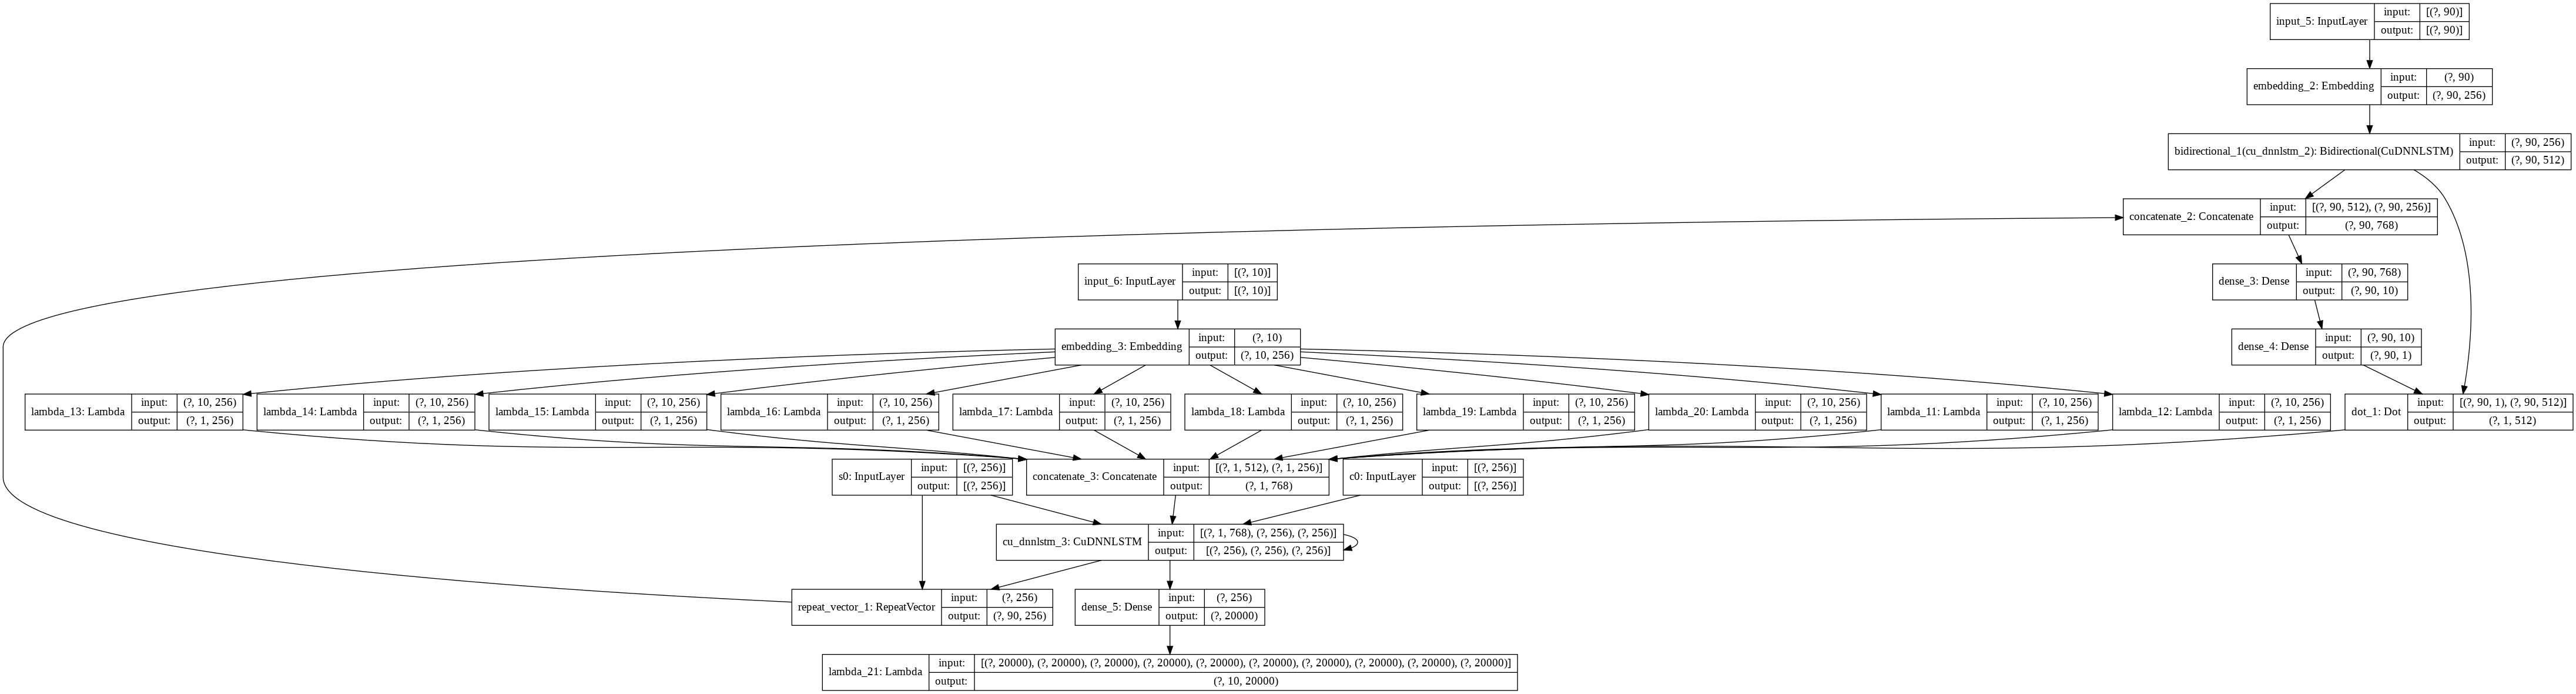

In [161]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [0]:
z = np.zeros((len(encoder_inputs), latent_dim))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [184]:
r = model.fit([encoder_inputs, decoder_inputs, z, z], decoder_targets,epochs=40,callbacks = [es],batch_size = 64,validation_split=0.2)

Epoch 1/40
3750/3750 [==============================] - 977s 261ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.5879 - val_loss: 2.6039 - val_sparse_categorical_accuracy: 0.5742
Epoch 2/40
3750/3750 [==============================] - 973s 260ms/step - loss: 2.2309 - sparse_categorical_accuracy: 0.5918 - val_loss: 2.6250 - val_sparse_categorical_accuracy: 0.5727
Epoch 00002: early stopping


In [185]:
model_json = model.to_json()
with open("drive/My Drive/Attention/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("drive/My Drive/Attention/model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
json_file = open('drive/My Drive/Attention/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [0]:
from tensorflow.python.keras.models import model_from_json


In [0]:
encoder_model = Model(encoder_input_placeholder,encoder_outputs)

In [0]:
encoder_outputs_as_input = Input(shape=(max_len_input,2*latent_dim))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
context = one_step_attention(encoder_outputs_as_input,initial_s)
decoder_lstm_input = context_last_word_concat_layer([context,decoder_inputs_single_x])
o,s,c = decoder_lstm(decoder_lstm_input, initial_state =[initial_s,initial_c])
decoder_output = decoder_dense(o)
decoder_model = Model(inputs = [decoder_inputs_single,encoder_outputs_as_input,initial_s,initial_c],outputs = [decoder_output,s,c])

In [128]:
i = 4
input_seq = encoder_inputs[i:i+1]
input_seq

array([[17,  1, 17, 90, 91, 92, 11,  1, 93, 94,  1, 95, 96,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [0]:
enc_out = encoder_model.predict(input_seq)

In [0]:
target_seq = np.zeros((1, 1))

target_seq[0, 0] = word2idx_outputs['_start_']

eos = word2idx_outputs['_end_']

In [0]:
s = np.zeros((1, latent_dim))
c = np.zeros((1, latent_dim))
output_sentence =[]
test = []
ne = []

In [0]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [0]:
for _ in range(10):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        
    ne.append(o)
    idx = np.argmax(o.flatten())
    test.append(idx)


    if eos == idx:
      break
    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    target_seq[0, 0] = idx


In [133]:
print(output_sentence)

[]
